<a href="https://colab.research.google.com/github/aunz/ds/blob/master/Fashion_Articles_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognising Fashion Articles with Convolution Neural Network (CNN)

Fashion-MNIST is a dataset of Zalando's article images. It contains 60,000 images (28 × 28, pixel) in the train set and 10,000 images in the test set. There are 10 labels: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag and Ankle boot.

This dataset can be used in place of the digit MNIST dataset. The digit dataset has been considered "too easy" because classic machine learning algorithms can achieve 97% accuracy easily, and CNN can achieve 99.7%.

In comparison, classic machine learning algorithms only achieve less than 90% accuracy on the fashion MNIST dataset, and CNN can only achieve ~94% accuracy.

Ref: https://github.com/zalandoresearch/fashion-mnist

In this notebook, we are going to use CNN, step by step, to go from an accuracy of less than 90% to an accuracy of ~94% and possibly higher.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphs

from keras.datasets import fashion_mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Flatten, Dropout, InputLayer
from keras.optimizers import Adam, Adamax, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
# load the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# reshape and normalise the data

X_train = X_train.reshape(-1, 28, 28, 1) / 255
y_train = to_categorical(y_train)

X_test = X_test.reshape(-1, 28, 28, 1) / 255
y_test = to_categorical(y_test)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f'''Shapes
X_train: {X_train.shape};\ty_train: {y_train.shape}
X_test: {X_test.shape};\ty_test: {y_test.shape}''')

4423680/4422102 [==============================] - 1s 0us/step
Shapes
X_train: (60000, 28, 28, 1);	y_train: (60000, 10)
X_test: (10000, 28, 28, 1);	y_test: (10000, 10)


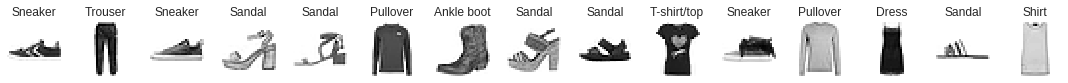

In [51]:
# check out some random images
plt.figure(figsize=(15, 2))
for i, n in enumerate(np.random.choice(range(60000), 15)):
    plt.subplot(1, 15, i + 1)
    plt.imshow(X_train[n].reshape(28, 28), cmap='binary')
    plt.xticks(())
    plt.yticks(())
    plt.title(labels[np.argmax(y_train[n])])

plt.tight_layout()

In [0]:
from copy import deepcopy

def train(make_model, n = 5, optimizer = lambda: 'rmsprop', callbacks = lambda: [EarlyStopping(patience=5, verbose=1)], verbose=0):
    # given a model, train it for n times and plot the associated metrics
    # make_model, optimizer and callbacks should be provided as a function as each time the functions are called, brand new instances are created in the for loop below. Use this because can't use deepcopy

    models = [] # to hold the model weights
    hists = [] # contains all the history
    
    make_model(None).summary()
    
    plt.figure(figsize=(4 * (n + 2), 8)) # the figure

    for i in range(n):
        model = make_model(i)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer(), metrics=['accuracy'])
        hist = model.fit(X_train, y_train, batch_size=256, epochs=50, validation_data=(X_test,y_test), callbacks=callbacks(), verbose=verbose)        
        hists.append(hist)
        
        models.append(model) # store the model
#         model.set_weights(initial_weights) # restore to the original weights

        r = range(2, len(hist.history['acc']) + 1) # starting from epoch 2, ignore the first epoch
        plt.subplot(2, n + 1, i + 2) # plot the loss history, starting with subplot 3
        plt.plot(r, hist.history['loss'][1:], '.-', label='Train loss') # ignore the first epoch
        plt.plot(r, hist.history['val_loss'][1:], '.-', label='Val loss')
        plt.legend()
        
        plt.subplot(2, n + 1, i + 2 + n + 1) # plot the acc history, starting with subplot 3
        plt.plot(r, hist.history['acc'][1:], '.-', label='Train acc')
        plt.plot(r, hist.history['val_acc'][1:], '.-', label='Val acc')
        plt.legend()

    
    plt.subplot(2, n + 1, 1) # plot the loss summary at the first subplot
    metrics = ['loss'] * n + ['val_loss'] * n 
    values = np.concatenate([
        [i.history['loss'][-1] for i in hists],
        [i.history['val_loss'][-1] for i in hists],
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Loss')
    values = values.reshape(2, -1)
    print('Loss', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))
    
    plt.subplot(2, n + 1, n + 2) # plot the acc summary at the second subplot
    metrics = ['acc'] * n + ['val_acc'] * n
    values = np.concatenate([
        [i.history['acc'][-1] for i in hists],
        [i.history['val_acc'][-1] for i in hists]
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Accuracy')
    values = values.reshape(2, -1)
    print('\nAcc', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))

    plt.tight_layout()
    
    return models, hists

### Trial 0

Firstly, we try normal neural networks with 2 hidden layers, each with 64 neurons

We got a mean accuary of ~0.88 and ~0.84 for the train and test set respectively.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 64)        128       
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 64)        4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                501770    
Total params: 506,058
Trainable params: 506,058
Non-trainable params: 0
_________________________________________________________________
Epoch 00010: early stopping
Epoch 00011: early stopping
Epoch 00014: early stopping
Epoch 00026: early stopping
Epoch 00009: early stopping
Loss [0.32796284 0.32394044 0.30176053 0.26006705 0.3367105 ] [0.44678089 0.41359531 0.41919604 0.46956931 0.40897755]
Mean [0.3

([<keras.models.Sequential at 0x7f3ee6f1c2b0>,
  <keras.callbacks.History at 0x7f3ee1058320>])

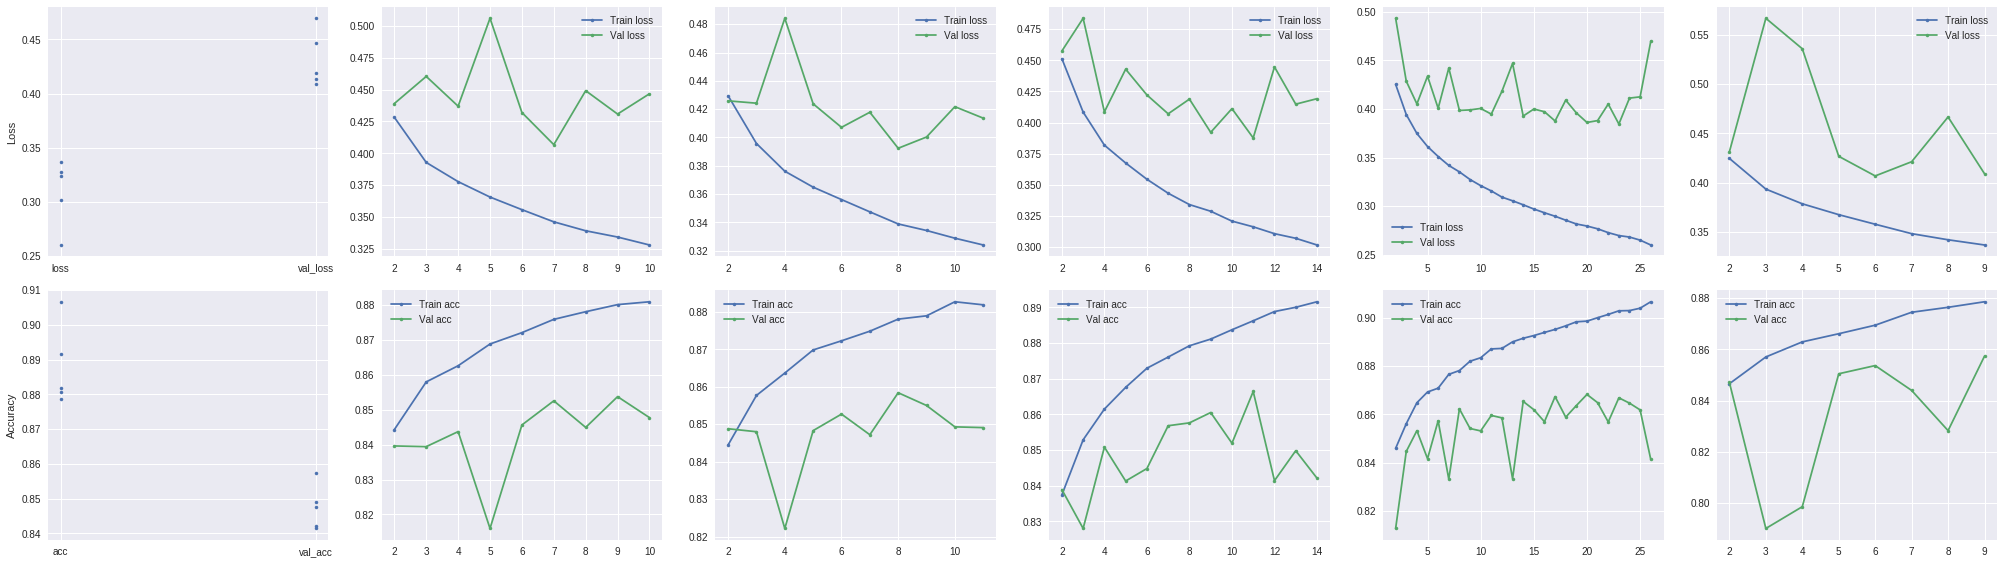

In [5]:
# Try just normal neural networks with 2 hidden layers, each with 64 neurons
%%time

_ = train(lambda x: Sequential([
    Dense(64, input_shape=(28, 28, 1), activation='relu'),
    Dense(64, activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
]))

### Trial 1

Now try with the most basic Convolution network, with just 1 convolution layer with the default kernel size of 3 and stride of 1.

I find the animations in http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html explain kernel size, stride and padding very well!

We obtained a mean accuracy of 0.9446 (train) and 0.8986 (test). Much better than the normal neural network.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_12 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________
Epoch 00013: early stopping
Epoch 00021: early stopping
Epoch 00018: early stopping
Epoch 00018: early stopping
Epoch 00017: early stopping
Loss [0.1794916  0.14338461 0.15533906 0.15565698 0.15738626] [0.32009035 0.30425915 0.31692231 0.30662149 0.29054246]
Mean [0.1582517  0.30768715] Std [0.0117314  0.01044945]

Acc [0.93755    0.94996667 0.94563333 0.94575    0.94423333] [0.8879 0.9049 0.8955 

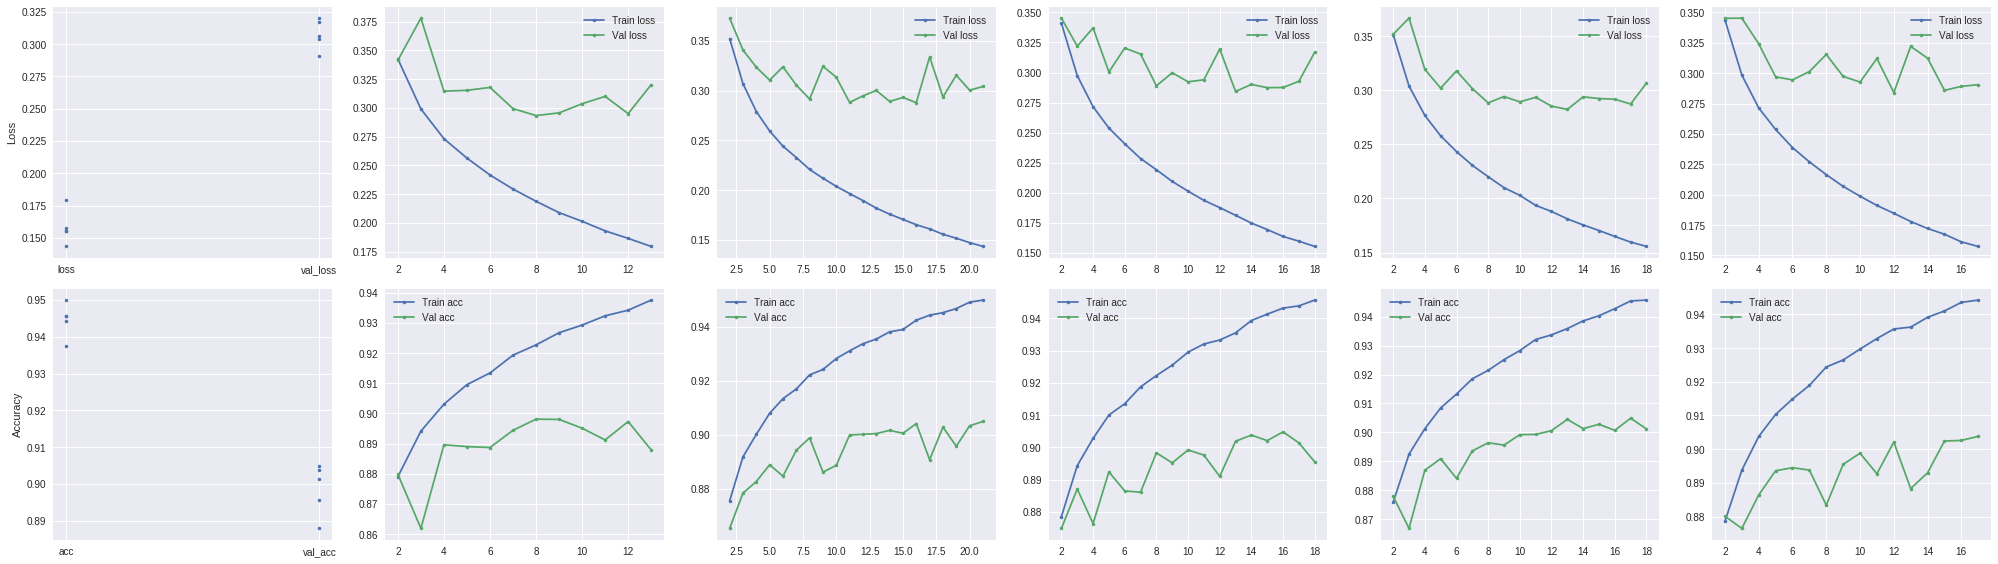

In [12]:
# now try with Convolution, the most basic setup
%%time
_ = train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')    
]))

### Trial 2
Changed the strides to 2

It doesn't seem to improve anything

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Epoch 00016: early stopping
Epoch 00017: early stopping
Epoch 00016: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Loss [0.23576201 0.23307949 0.23701177 0.25558923 0.26133085] [0.30884161 0.30112567 0.31132829 0.3374401  0.32072523]
Mean [0.24455467 0.31589218] Std [0.01156795 0.01246002]
Acc [0.9171     0.91783333 0.91673333 0.90956667 0.90741667] [0.8884 0.8913 0.8905 0.8

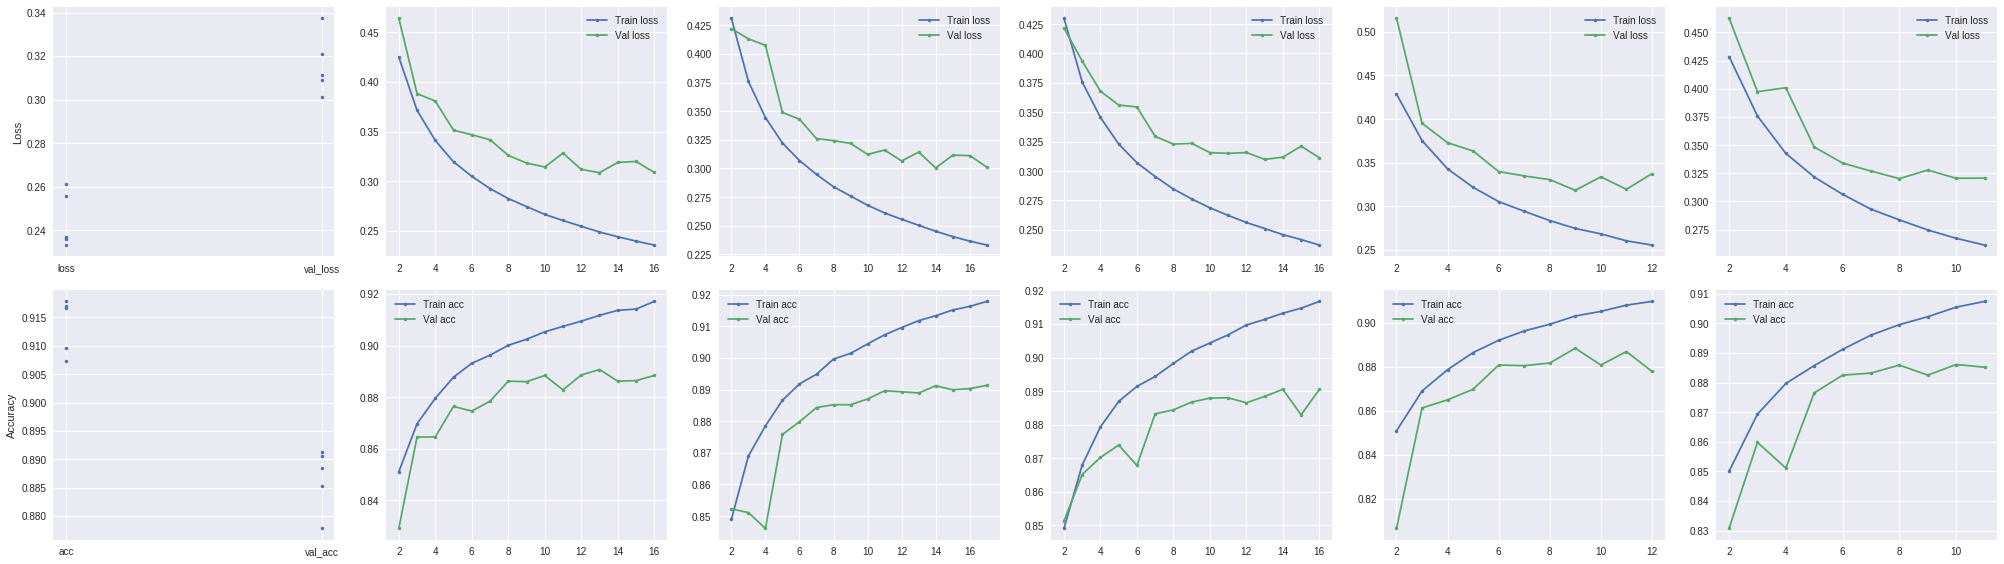

In [8]:
# increase the stride to 2
%%time

models, hists = train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, strides=2, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')
]));

### Trial 3
Set the padding to "same".

It doesn't seem to improve anything either.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
flatten_31 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________
Epoch 00014: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00020: early stopping
Epoch 00014: early stopping
Loss [0.25080241 0.2313212  0.24189907 0.22126721 0.2507836 ] [0.3202025  0.31222611 0.33909668 0.30562652 0.32476935]
Mean [0.2392147  0.32038423] Std [0.01148686 0.01143471]
Acc [0.91103333 0.91881667 0.91481667 0.9219     0.91095   ] [0.8874 0.8915 0.8781 0.8

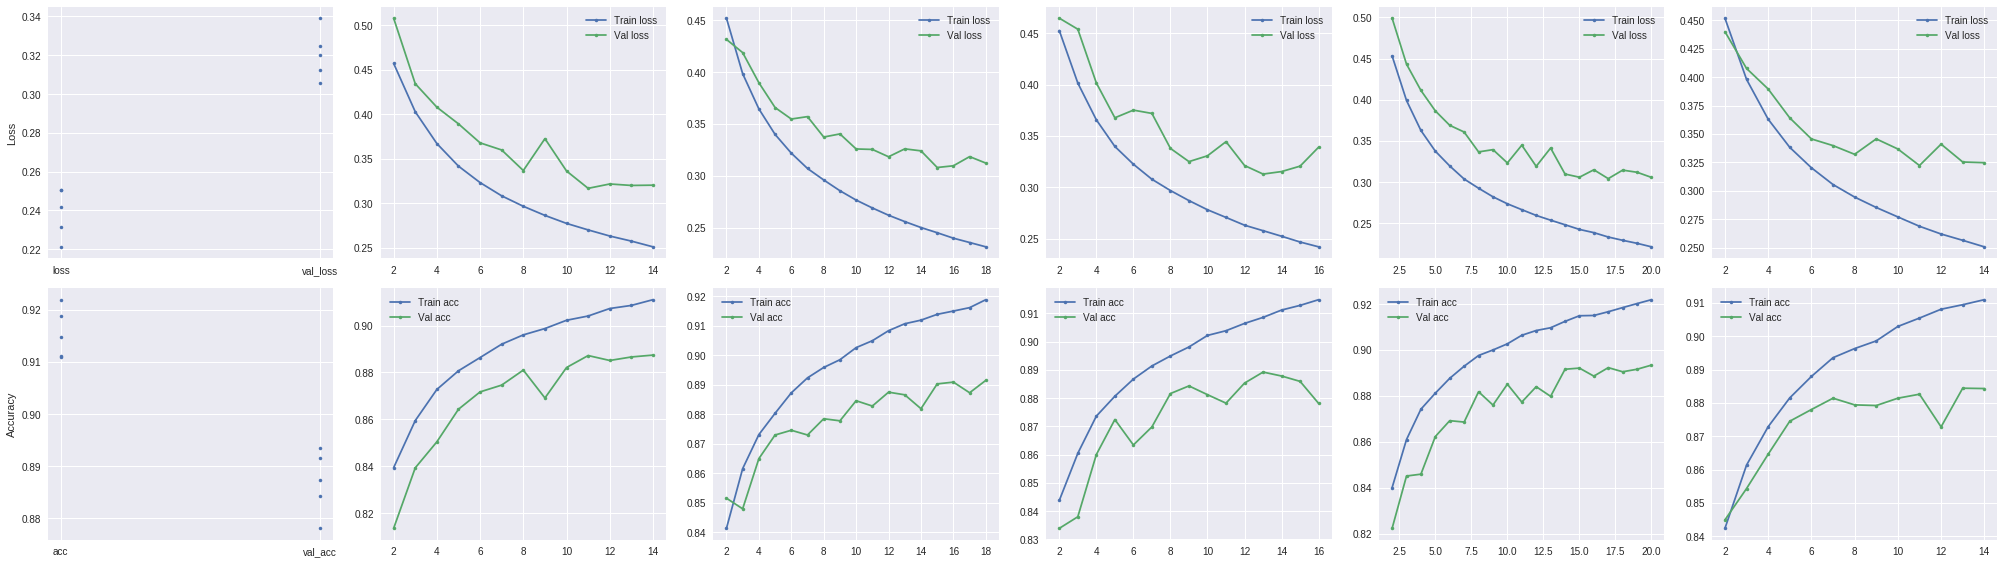

In [46]:
# set padding to 'same'
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')
]));

### Trial 4
Add another Dense layer

Average accuracies have increased for both train and test set. There are now over 2.7 millions trainable params.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_32 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               2769024   
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Loss [0.12686194 0.11044483 0.11176495 0.08427913 0.11425852] [0.29156072 0.32207396 0.30249613 0.31388811 0.28691212]
Mean 

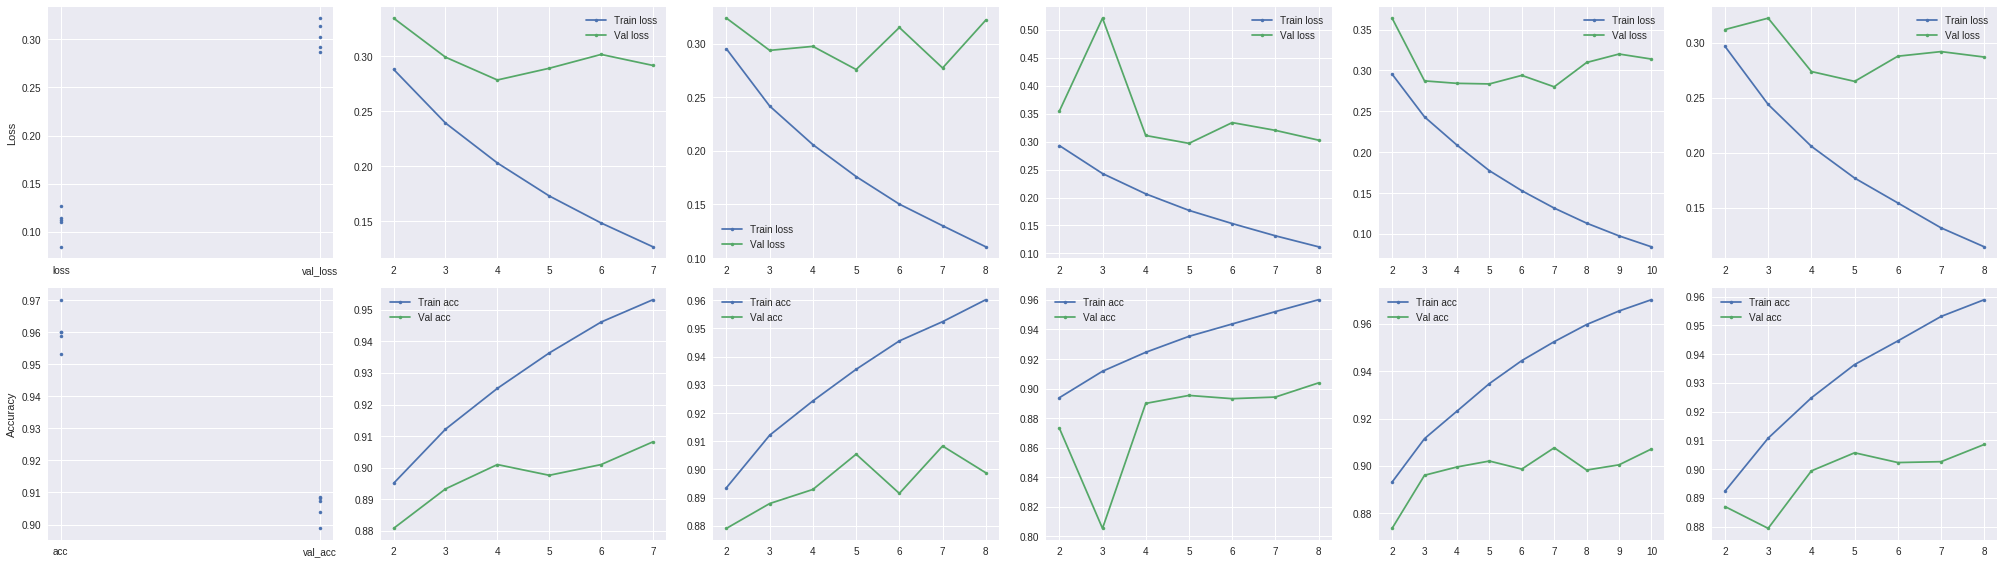

In [47]:
# Add another Dense layer
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(128, activation='relu'), # I just chose 128 randomly
    Dense(10, activation='softmax')
]));

### Trial 5
Increase the number of filter in the first Conv2D layer, from 32 to 64

The trainable param number is now over 5 millions! There isn't much improvement though.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
flatten_33 (Flatten)         (None, 43264)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               5537920   
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total params: 5,539,850
Trainable params: 5,539,850
Non-trainable params: 0
_________________________________________________________________
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00009: early stopping
Loss [0.08212663 0.10727052 0.0859035  0.09086804 0.07364564] [0.38037102 0.29732327 0.32941196 0.38115628 0.31708589]
Mean 

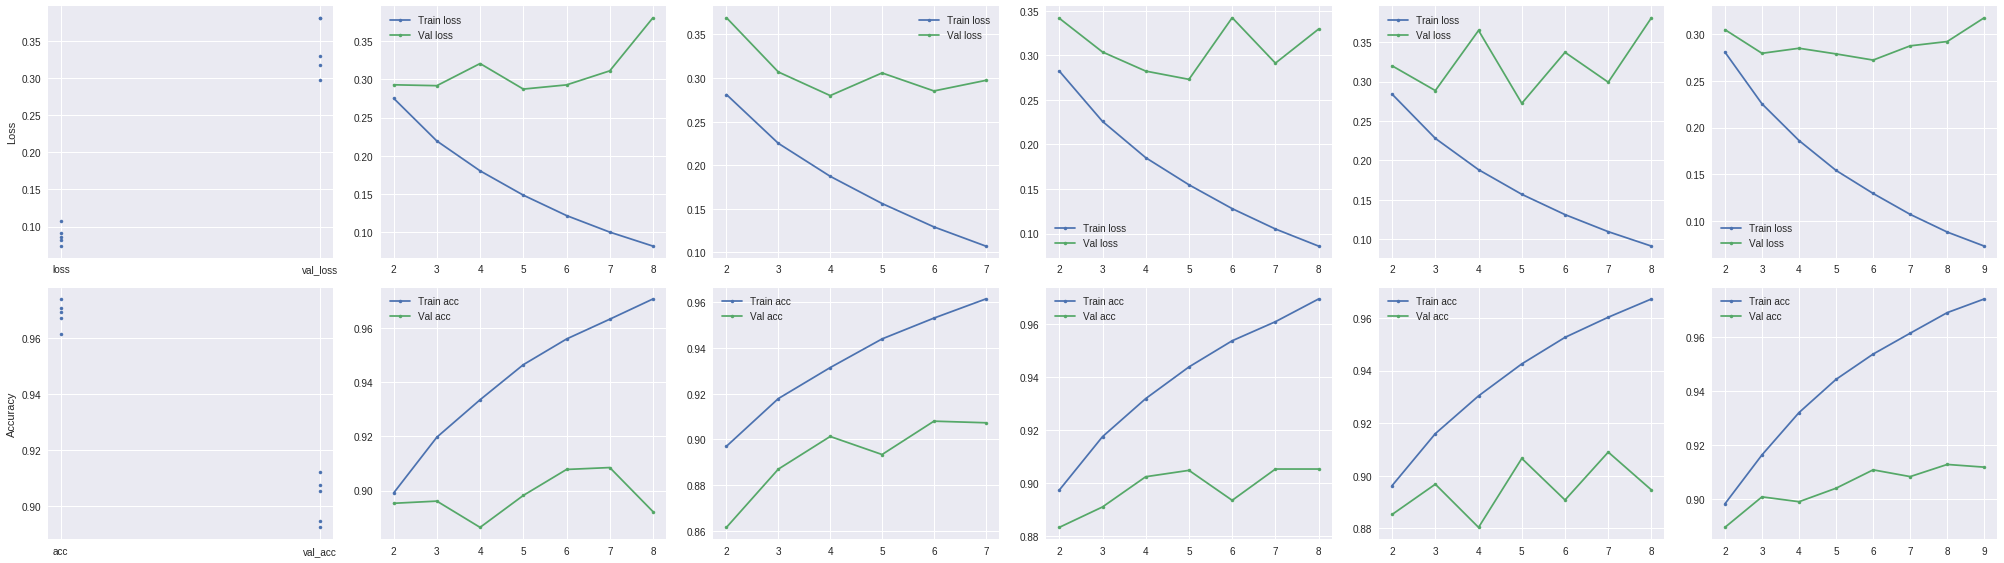

In [48]:
# more filters in the first Conv2D layer, from 32 to 64
%%time

train(lambda x: Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 6
Add a MaxPooling. This reduces the trainable params to about 700K.

Not too much improvement though.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopp

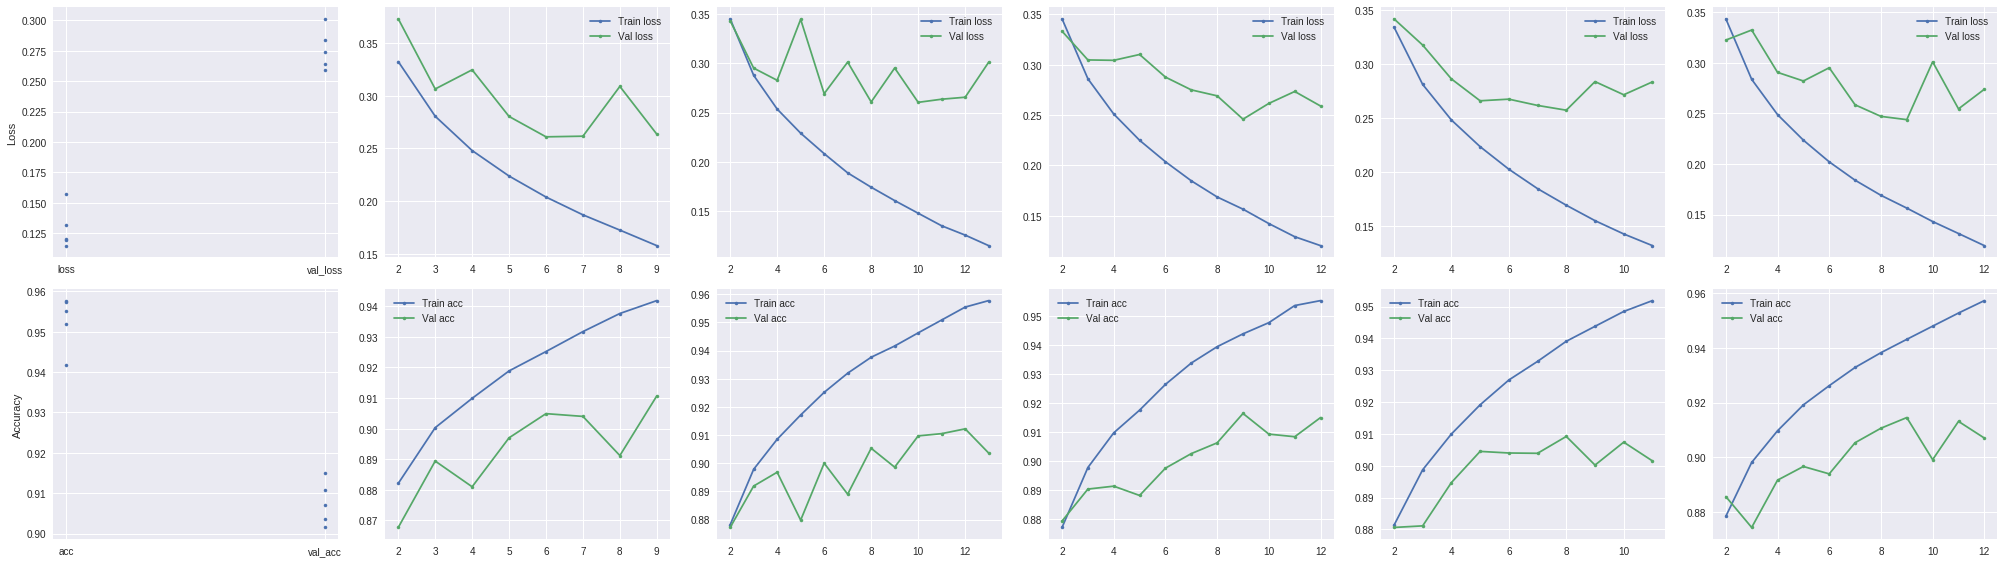

In [49]:
# add MaxPooling
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 7
Add BatchNormalization, this helps with weights and faster training.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_54 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_58 (Dense)             (None, 10)                1290      
Total para

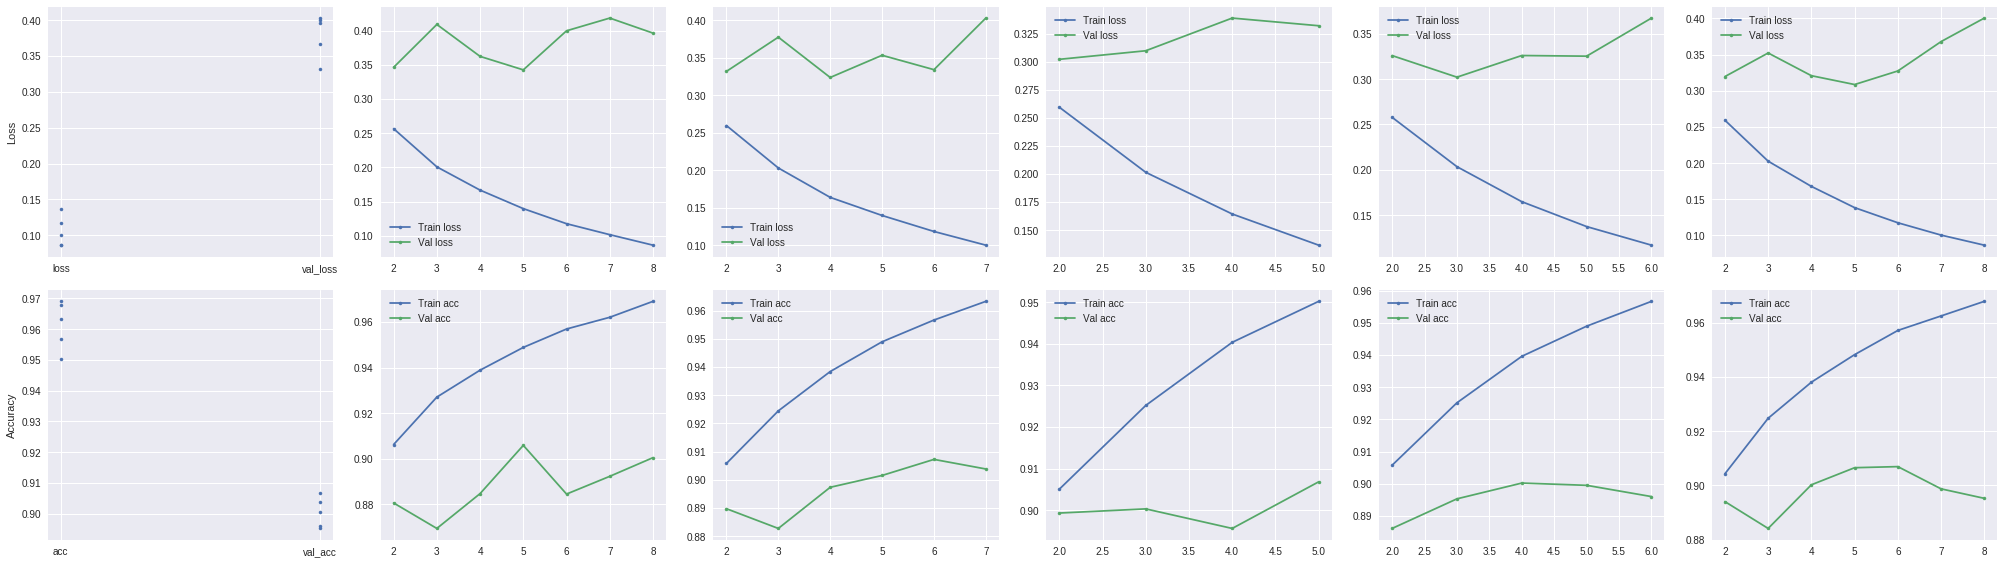

In [50]:
# add Batchnormalisation, to help with normalising weights 
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 8
Add 1 more set of Conv2D, Batch, MaxPooling

Doesn't seem to help with accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_58 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 32)          0         
__________

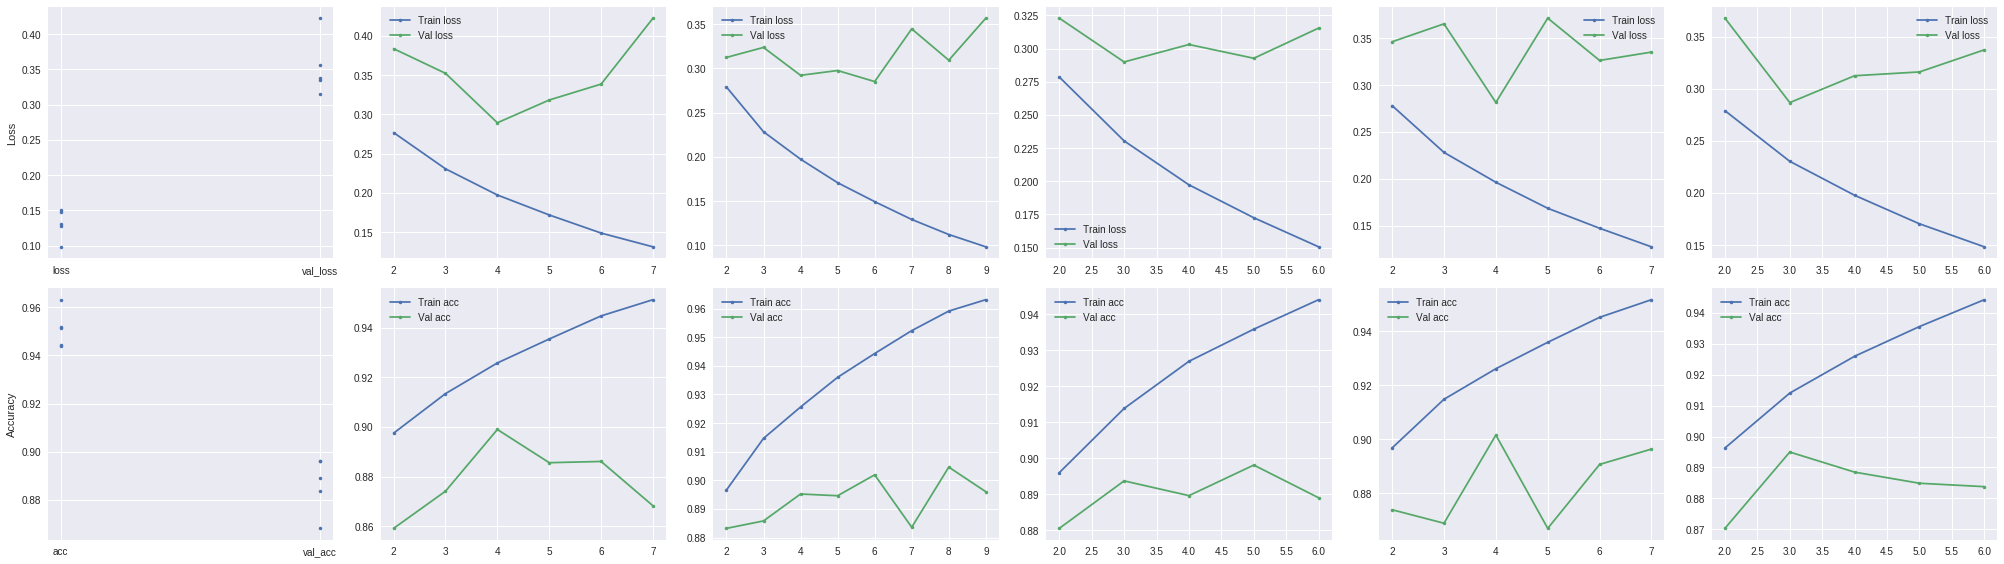

In [51]:
# add more Conv2D
%%time

def make_mode(x):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model);

### Trial 9
3 layers of Conv2D with increasing kernel size

A slight improvement. Mean train accuracy reaches 0.97 while mean test accuracy stays at ~0.90, it's a sight of overfitting.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_15 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_9 (Flatten)          (None, 11552)             0         
__________

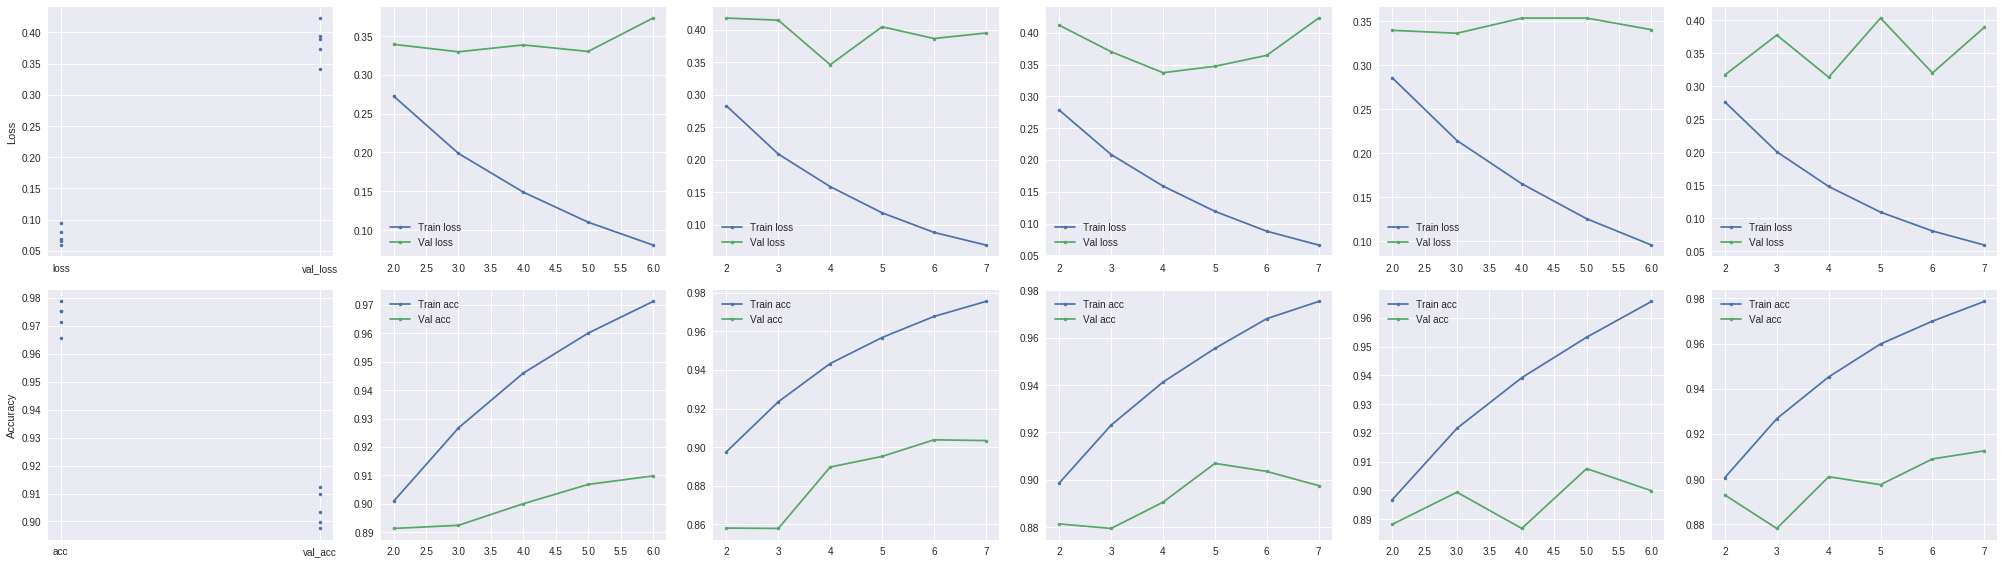

In [14]:
# 3 layers of Conv2D with increasing kernel size
%%time
def make_model(_):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model);

### Trial 10
Use Adam optimizer and ReduceLROnPlateau as callbacks

Seem to help a bit with accuracy

Now the train accuracy ~0.99, the test ~0.91, still overfitted.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_19 (Flatten)         (None, 11552)             0         
__________

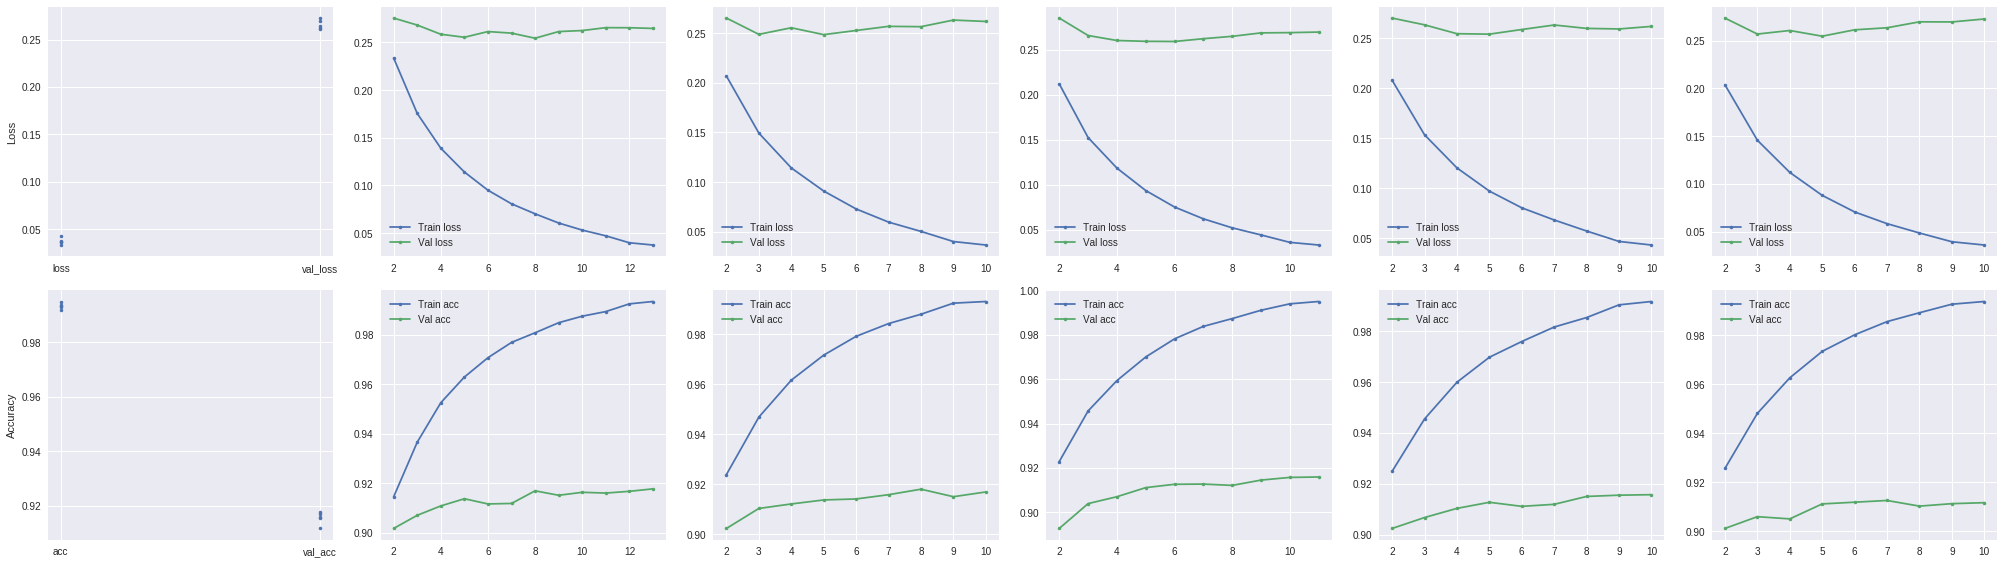

In [10]:
%%time
def make_model(_):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]

train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=0);

### Trial 11

Add some Dropout

Overfitting has been reduced. However the test accuracy still has not improved much, hovering around 0.92

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 19, 32)        25632     
__________

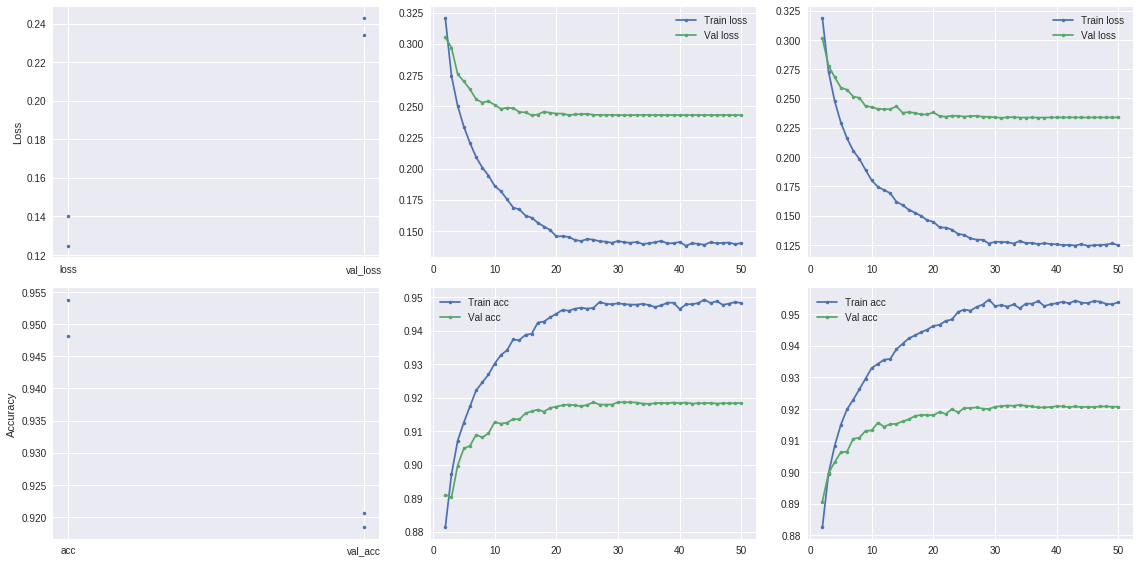

In [7]:
%%time
def make_model(_):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
#     EarlyStopping(patience=5, verbose=1)
]

train(make_model, n=2, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=1);

### Trial 12

Using 2 Conv2D with kernel size of 5 and "same" padding, followed by a MaxPooling

Test accuracy has improved to ~0.934, but overfitting is still evident

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               802944    
_________________________________________________________________
batch_normalization_25 (Batc (None, 128)               512       
__________

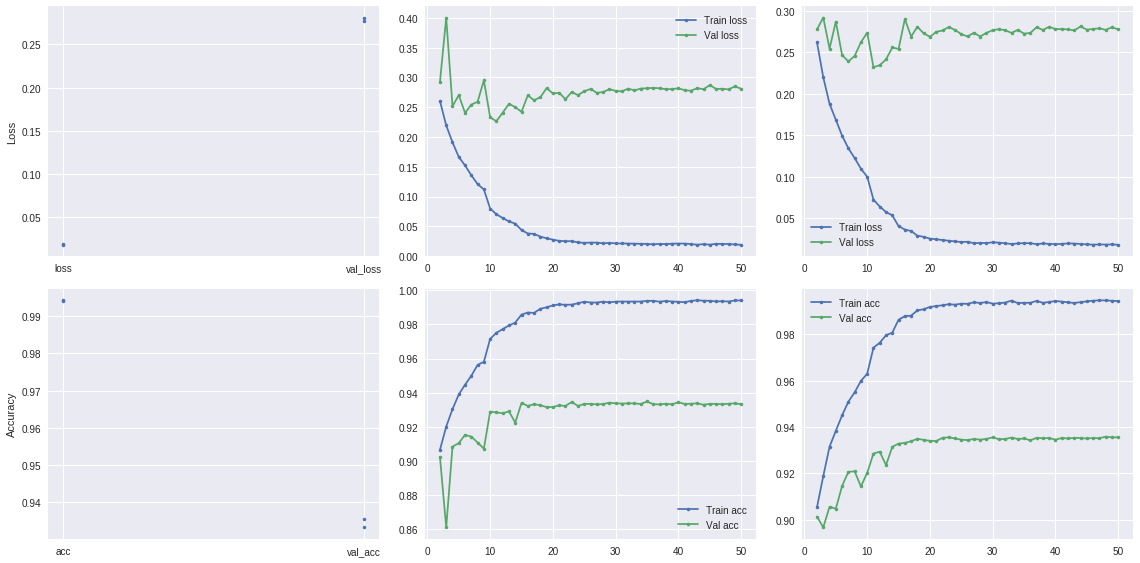

In [9]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model, n=2, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1);

### Trial 13

We will increase dropout rate a bit more

The test accuracy has decreased a bit to ~0.932

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
dropout_41 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               802944    
__________

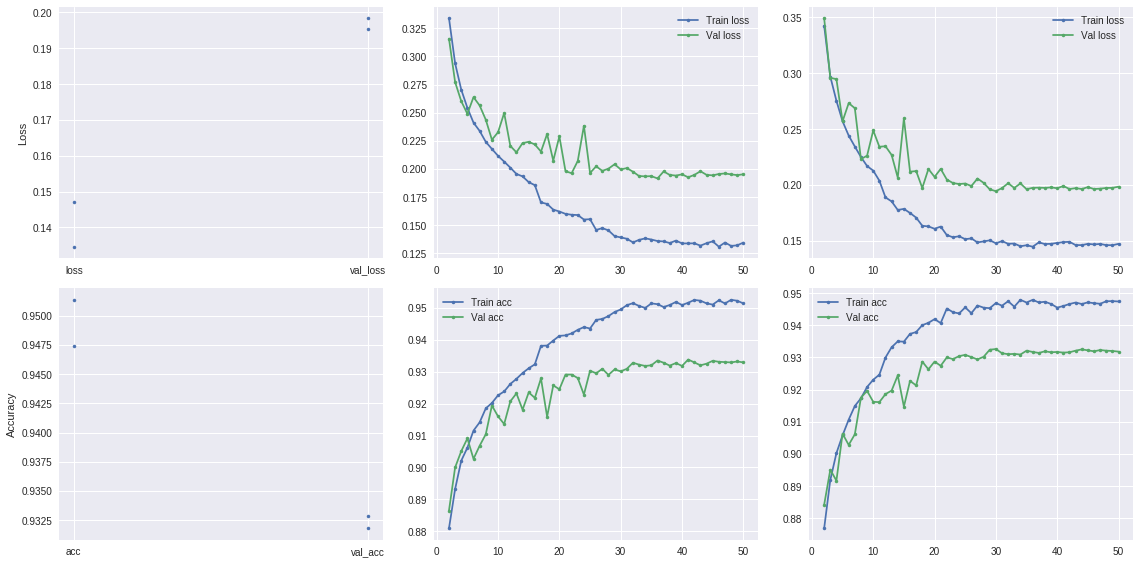

In [10]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Dropout(0.4))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model, n=2, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1);

### Trial 14

In the previous trial, we have over 800K params

Add more Conv2D and MaxPooling stacks, this also helps with reducing params to train. Less params = less overfitting, but also less capacity to learn.

Now there are only ~280K params

We have also edged the test accuracy to 0.938

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
__________

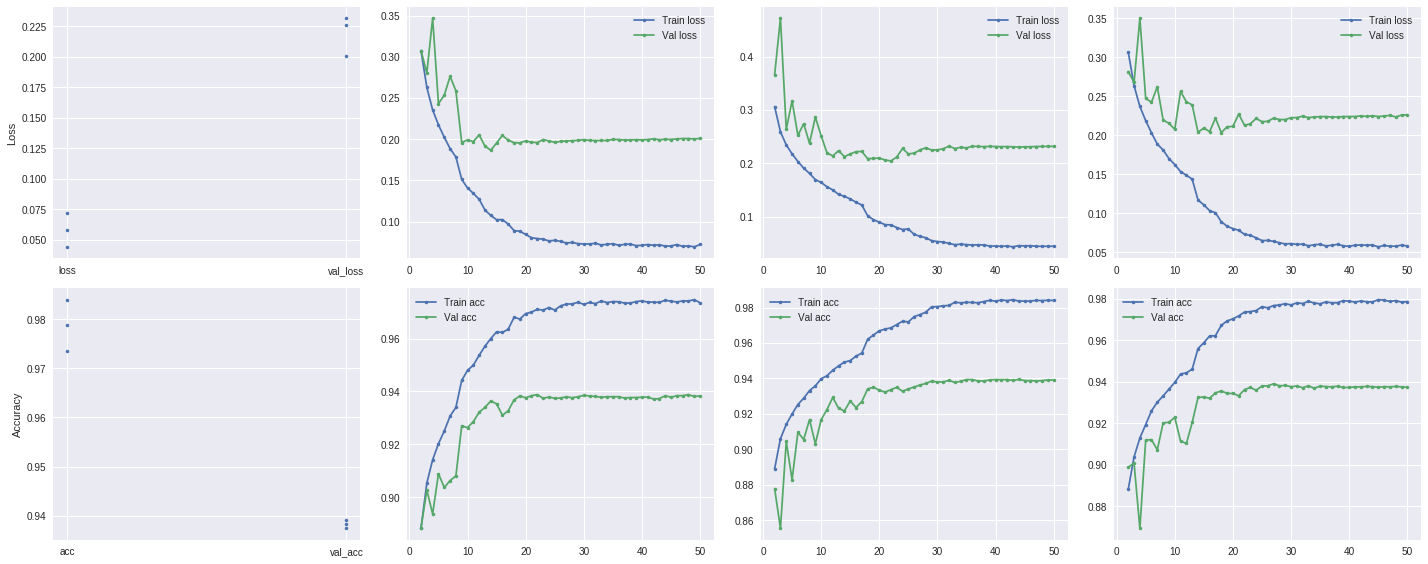

In [12]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 15

Add more Conv2D and MaxPooling

This reduces the trainable params to ~167K, but the test accuracy has decreased slightly to ~0.937

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_100 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 7, 7, 32)          0         
__________

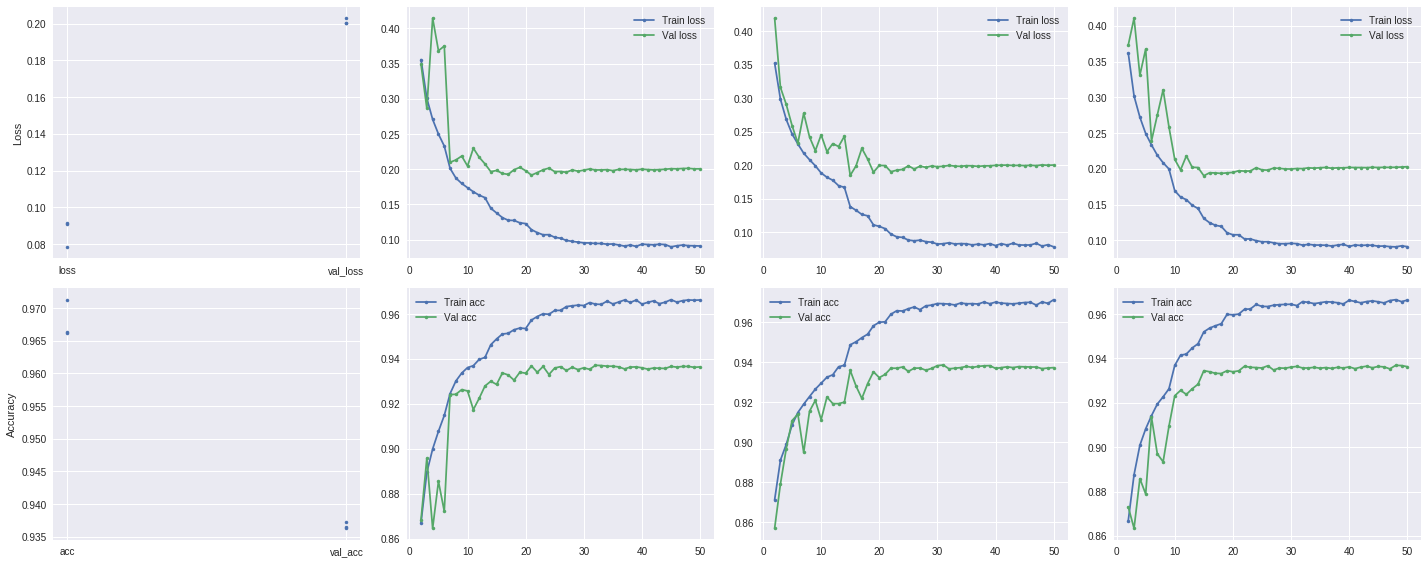

In [15]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model


train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 16

Reduce number of neurons in the Dense layer further.

Now the number of params is 56K only.

Test accuracy has decreased as well to ~0.936

For train, it's ~0.952. Possibly a bit too few params to learn properly

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_275 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_276 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_206 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_277 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_278 (Conv2D)          (None, 14, 14, 32)        9248      
__________

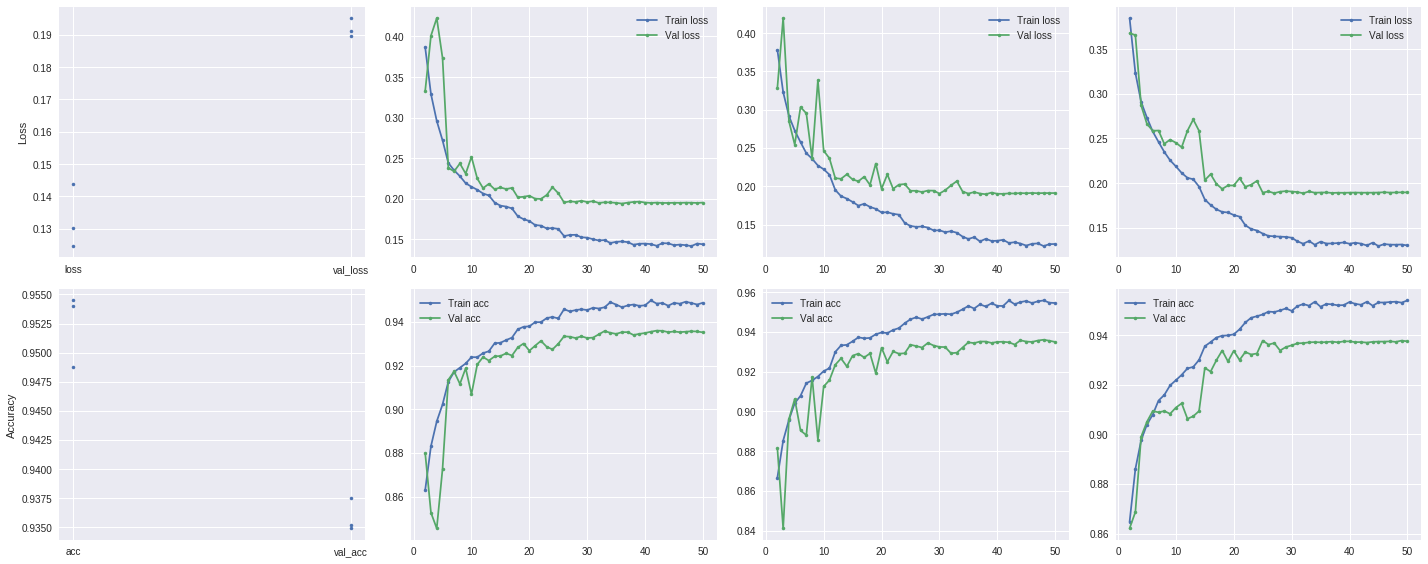

In [30]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    return model


train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 17

Lower the Dropout

Test accuracy is ~0.936

Train is ~0.969

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_311 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_230 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_313 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_314 (Conv2D)          (None, 14, 14, 32)        9248      
__________

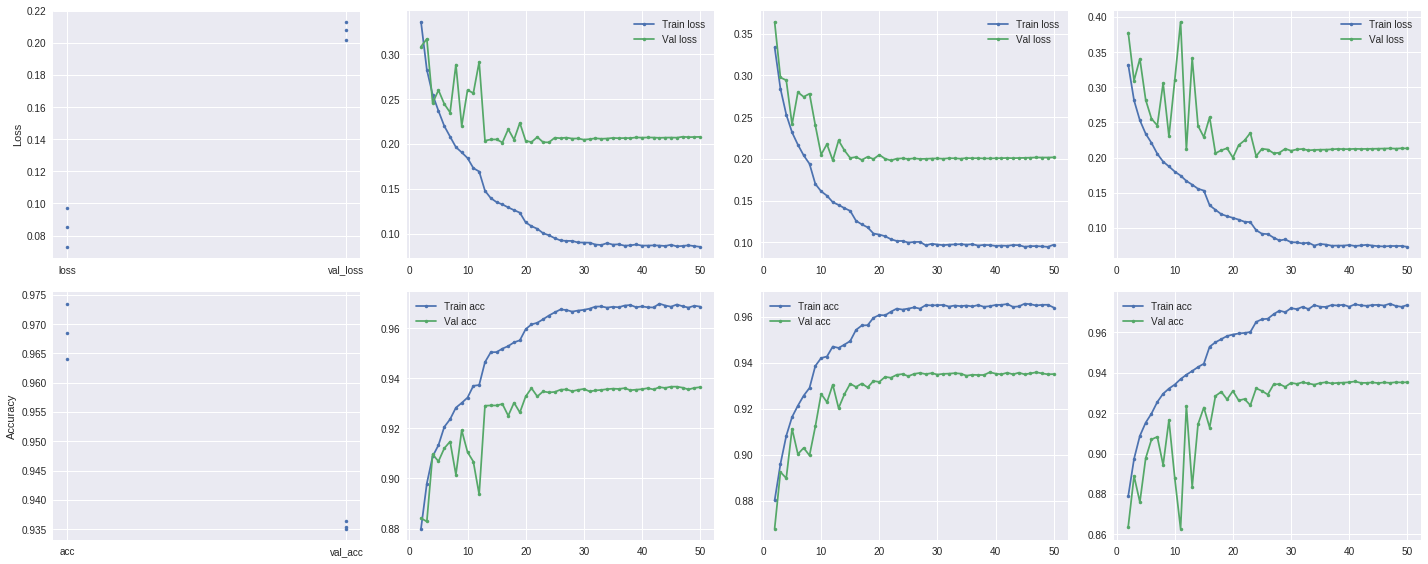

In [32]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    return model


train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 18

Use pool_size of 3

Not a good idea, test accuracy has dropped


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_335 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_336 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_246 (Dropout)        (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_337 (Conv2D)          (None, 9, 9, 32)          9248      
_________________________________________________________________
conv2d_338 (Conv2D)          (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 3, 3, 32)          0         
__________

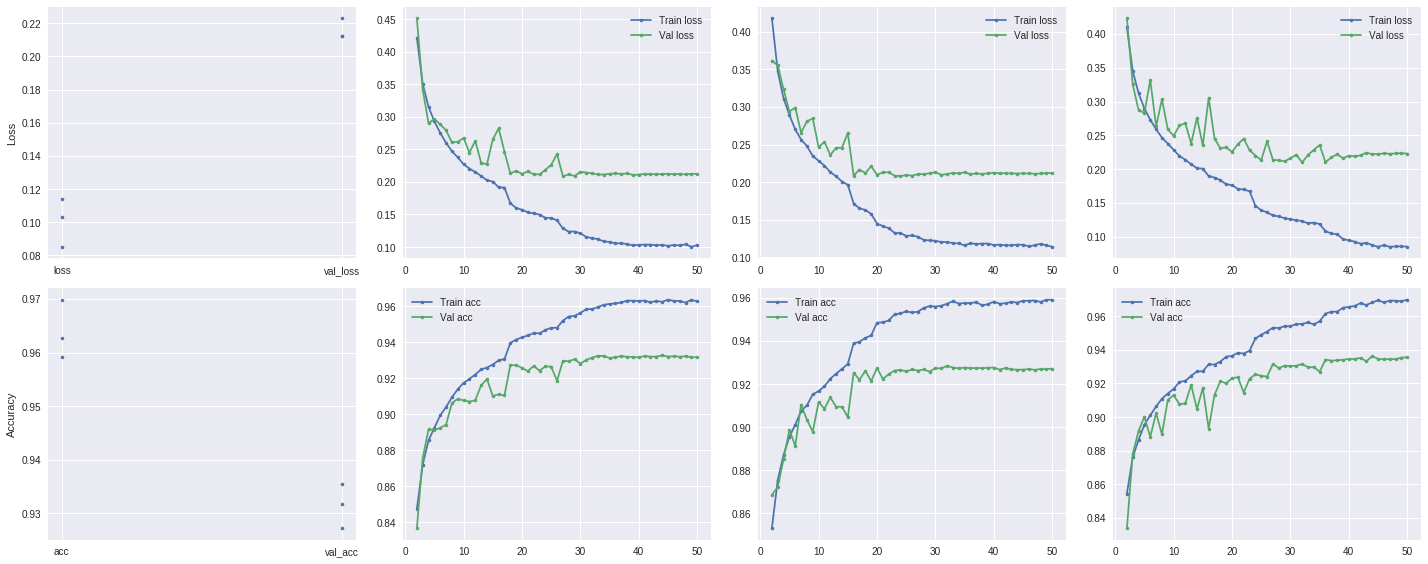

In [33]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    return model


train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trail 19
Remove one stack of Conv2D

Not good either, test accuracy has dropped further to ~0.931

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_359 (Conv2D)          (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_360 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_262 (Dropout)        (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_361 (Conv2D)          (None, 9, 9, 32)          25632     
_________________________________________________________________
conv2d_362 (Conv2D)          (None, 9, 9, 32)          25632     
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 3, 3, 32)          0         
__________

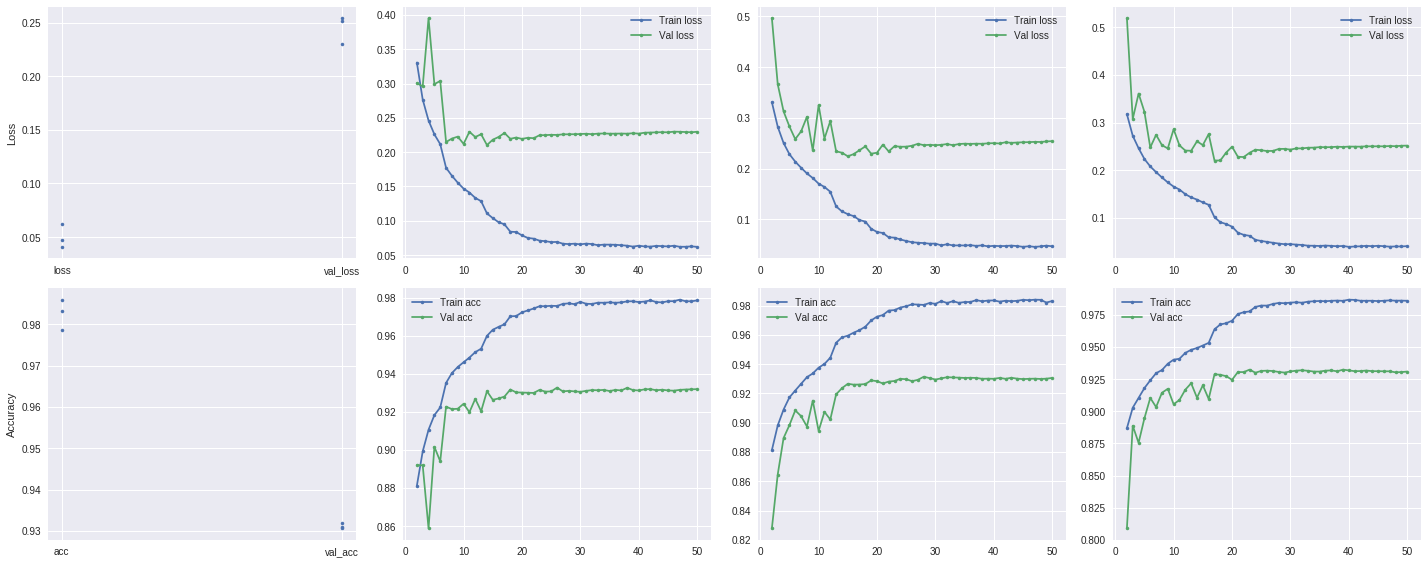

In [34]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D(3))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    return model


train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 20
Remove one Dense layer compare to trial 17

Now we have ~50K params

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
__________

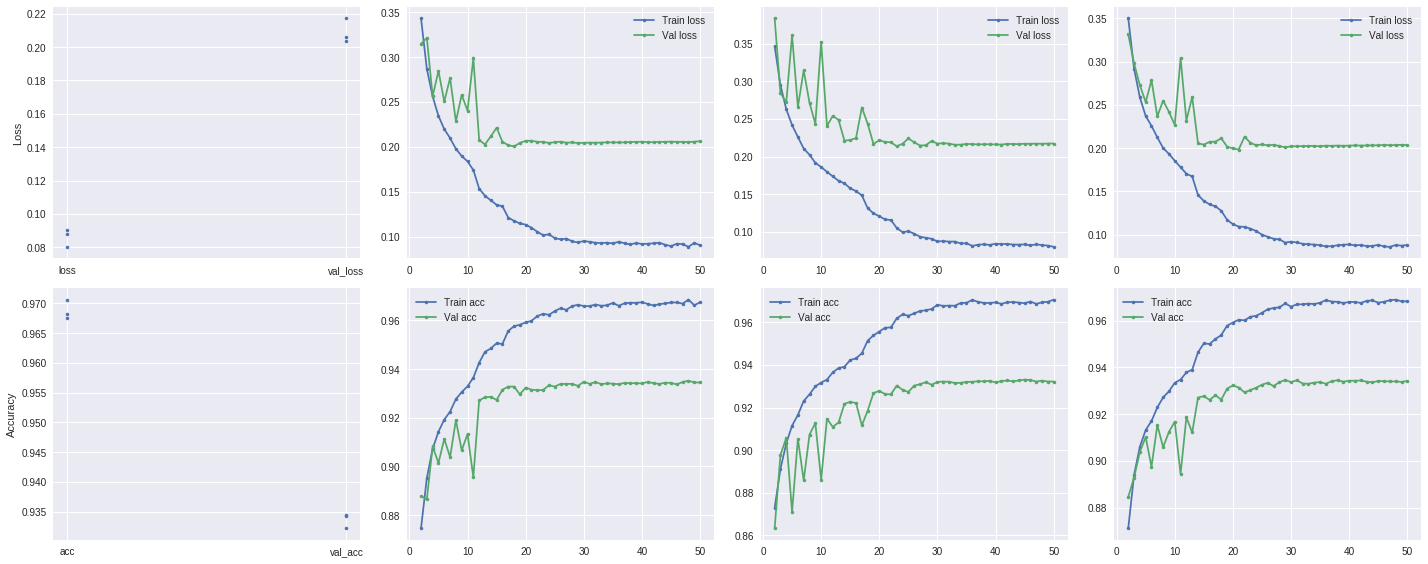

In [4]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial 21
Increase the Dropout rate to 0.15 compared to trial 20

Mean test accury is now ~0.937

Only ~49K params

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 32)        9248      
__________

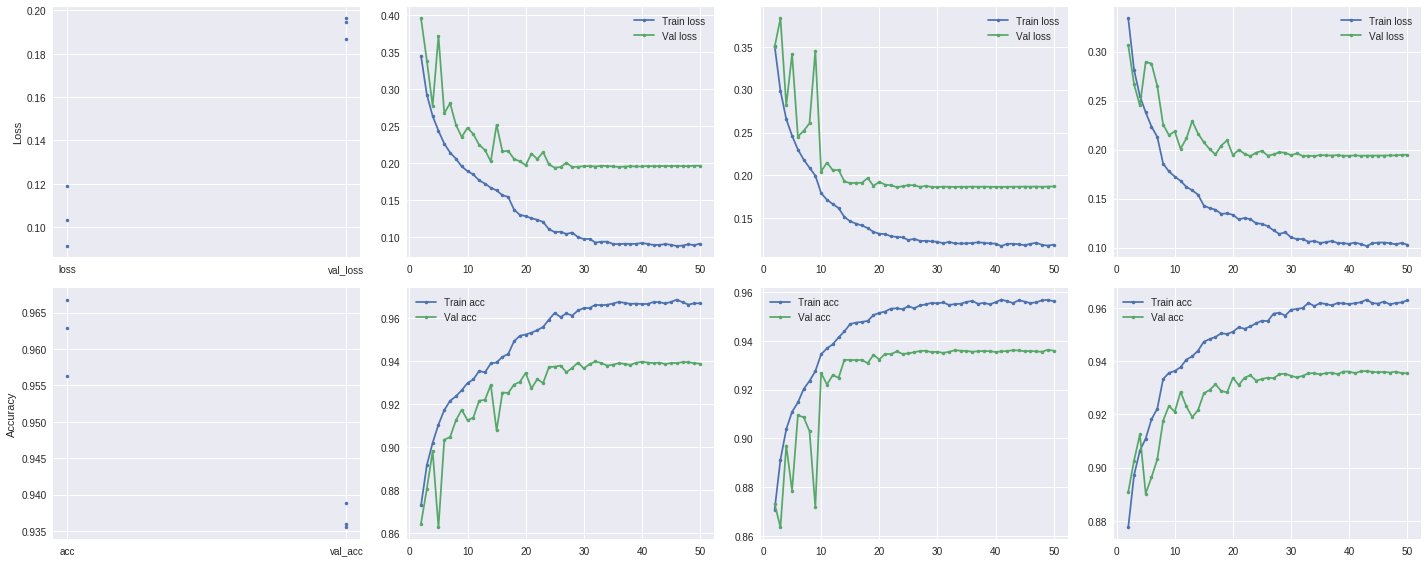

In [6]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial

Use SeparableConv2D

Not great, the test accuracy is only ~0.916

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_125 (Separa (None, 28, 28, 32)        89        
_________________________________________________________________
batch_normalization_88 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
separable_conv2d_126 (Separa (None, 28, 28, 32)        1856      
_________________________________________________________________
batch_normalization_89 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_46 (Dropout)         (None, 14, 14, 32)        0         
__________

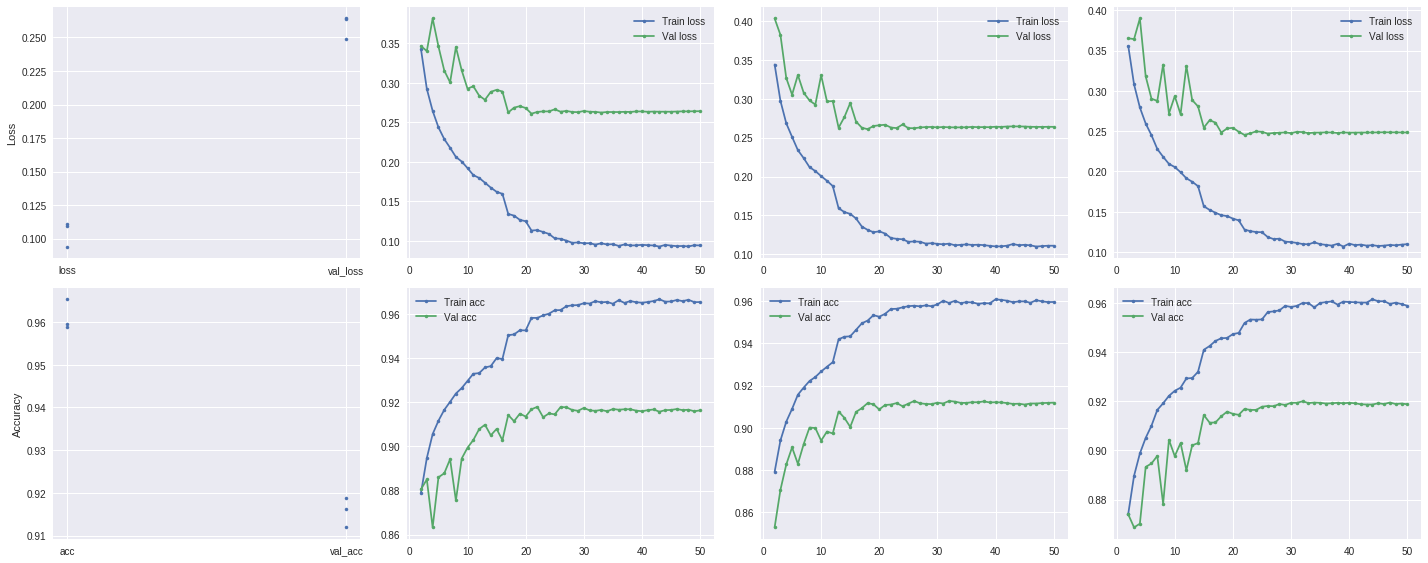

In [20]:
%%time

def make_model(i = None):
    model = Sequential()
    model.add(SeparableConv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, 5, padding='Same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(SeparableConv2D(64, 3, padding='Same', activation='relu'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(64, 3, padding='Same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model, n=3, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Trial

Use SeparableConv2D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 26, 26, 32)        73        
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 23, 23, 32)        1568      
_________________________________________________________________
batch_normalization_11 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 19, 19, 32)        1856      
_________________________________________________________________
batch_normalization_12 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 19, 32)        0         
__________

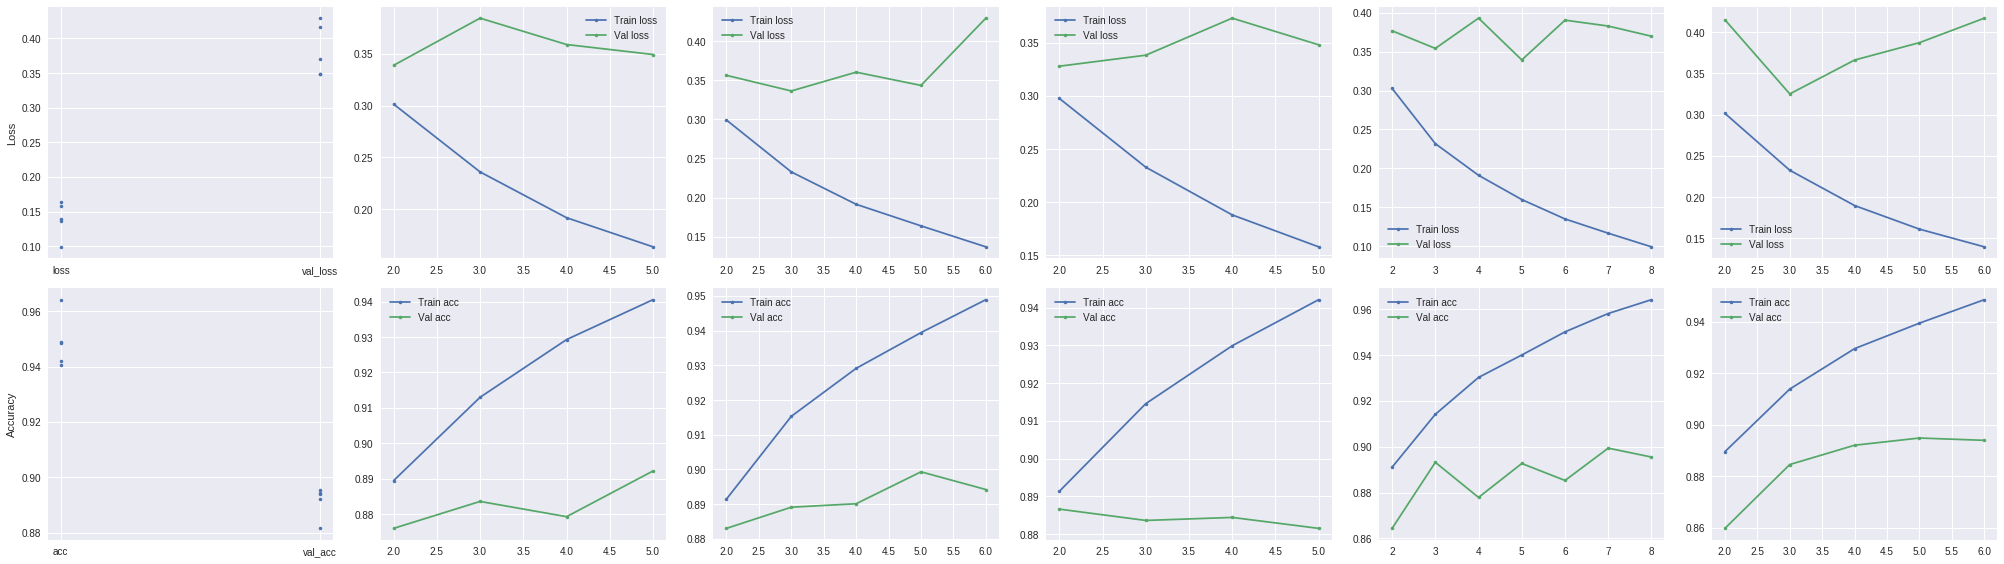

In [11]:
# Use SeparableConv2D
%%time

def make_model(x):
    model = Sequential()
    model.add(SeparableConv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(model);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 26, 26, 32)        73        
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 23, 23, 32)        1568      
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 19, 19, 32)        1856      
_________________________________________________________________
batch_normalization_15 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_7 (Flatten)          (None, 11552)             0         
__________

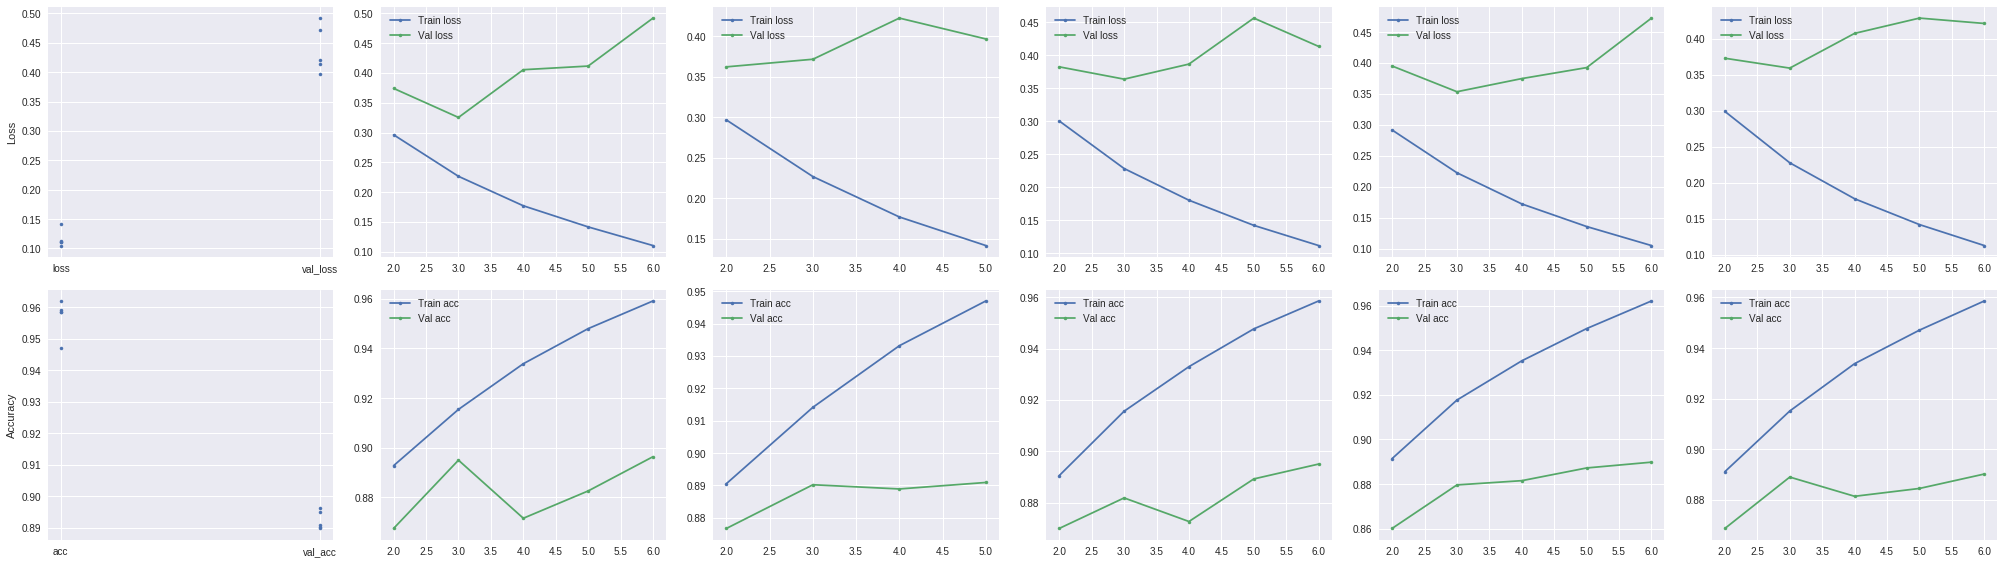

In [12]:
%%time

def make_model(x):
    model = Sequential()
    model.add(SeparableConv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(model);

### Trial, from someone else's work

Mean test accuracy is ~0.9389

With ~1.7M params



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

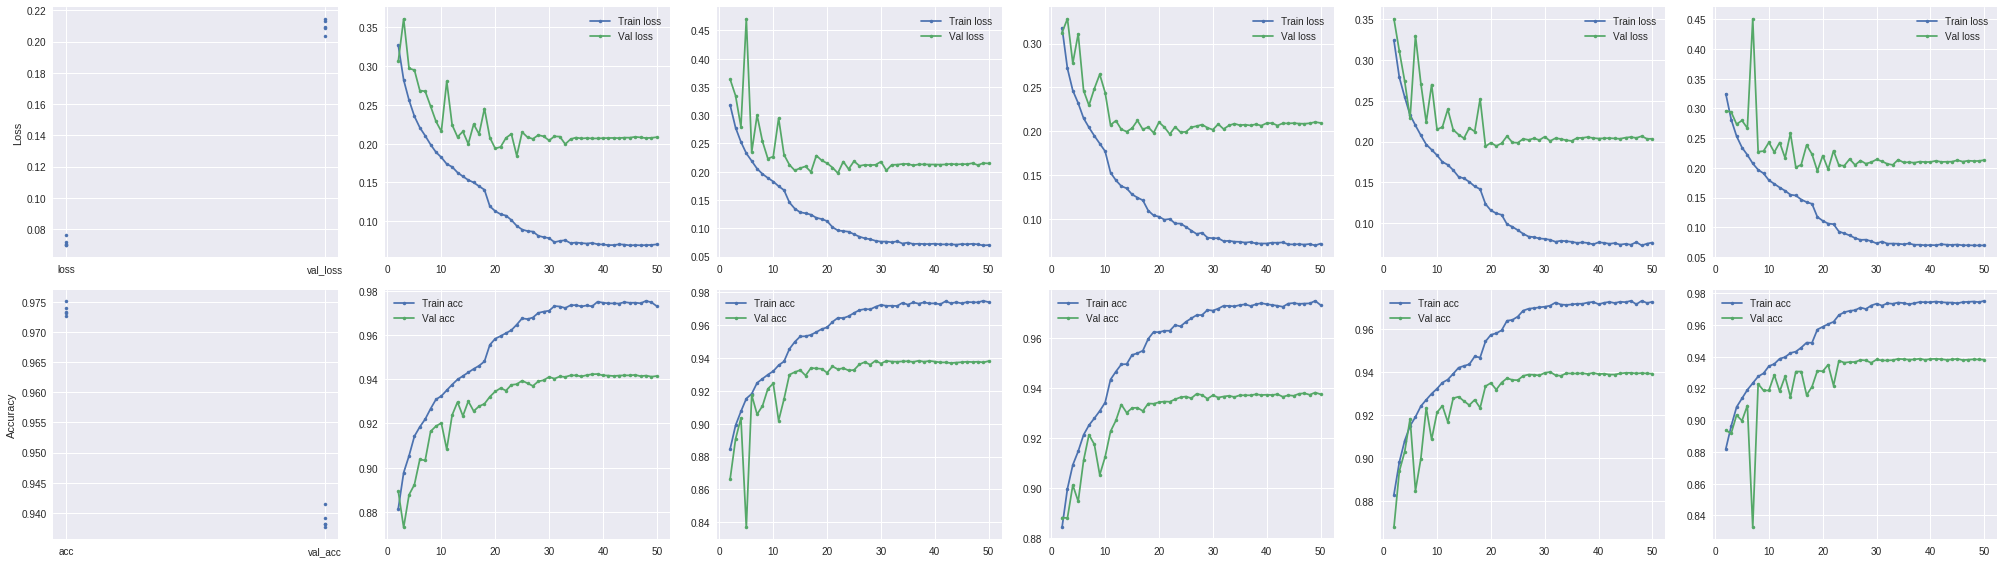

In [10]:
# https://github.com/khanguyen1207/My-Machine-Learning-Corner/blob/master/Zalando%20MNIST/fashion.ipynb
%%time

def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, 3, padding='Same', activation='relu'))
    model.add(Conv2D(64, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D(strides=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

models, hists = train(make_model, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=0, factor=0.5, min_lr=1e-5)], verbose=0)

### Trial, from another github repo

Mean test accuracy is only 0.89792, with ~1.9M params

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

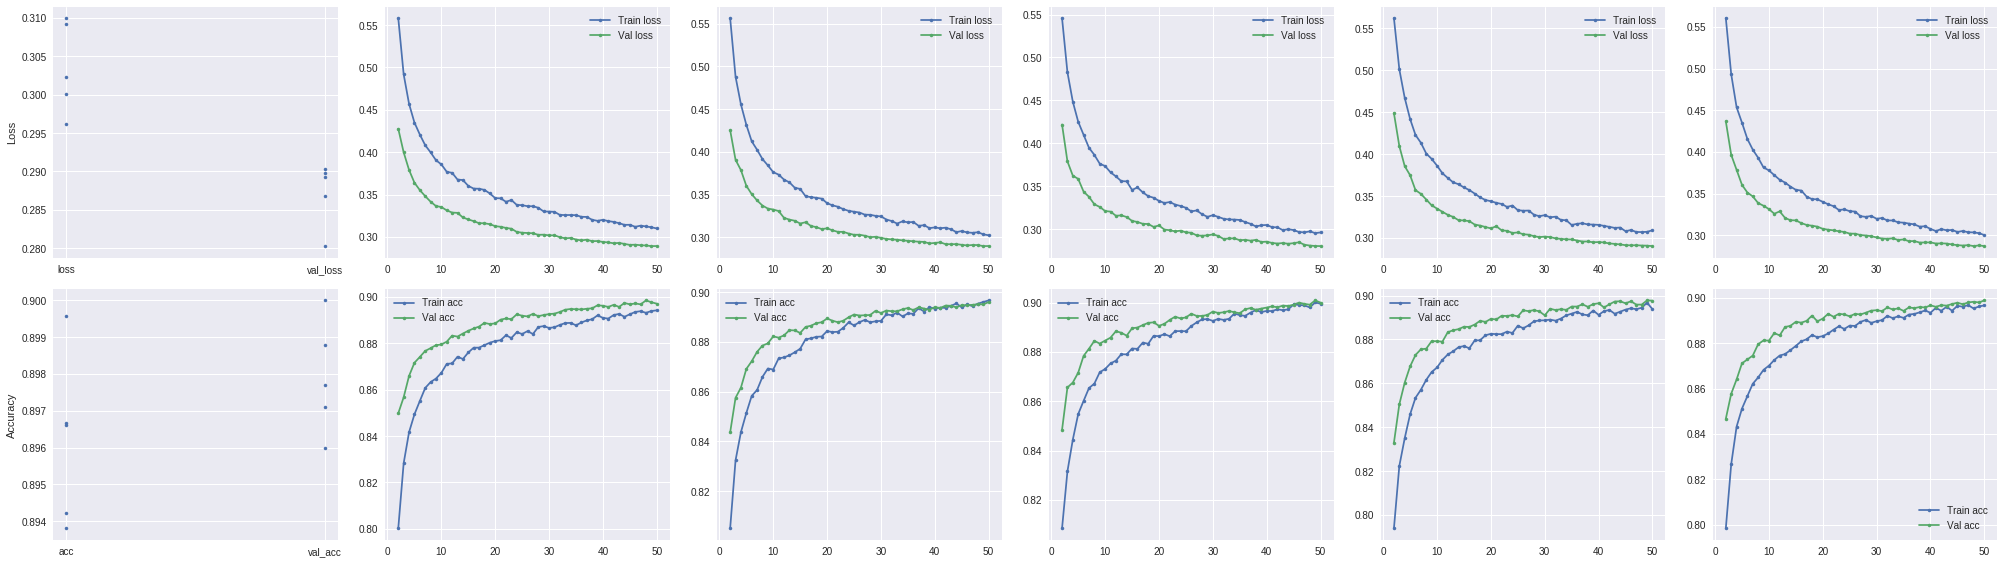

In [6]:
# https://github.com/Xfan1025/Fashion-MNIST/blob/master/fashion-mnist.ipynb

def make_model(x):
    model = Sequential()
    model.add(Conv2D(64, 5, activation='relu', input_shape=(28, 28, 1), bias_initializer='RandomNormal', kernel_initializer='random_uniform'))
    model.add(MaxPooling2D())
    model.add(Conv2D(512, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(10, activation='softmax'))
    
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]


train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=1);

### Trial, from another github repo

Test accuracy ~ 0.9295, with ~490K params

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1600)              0         
__________

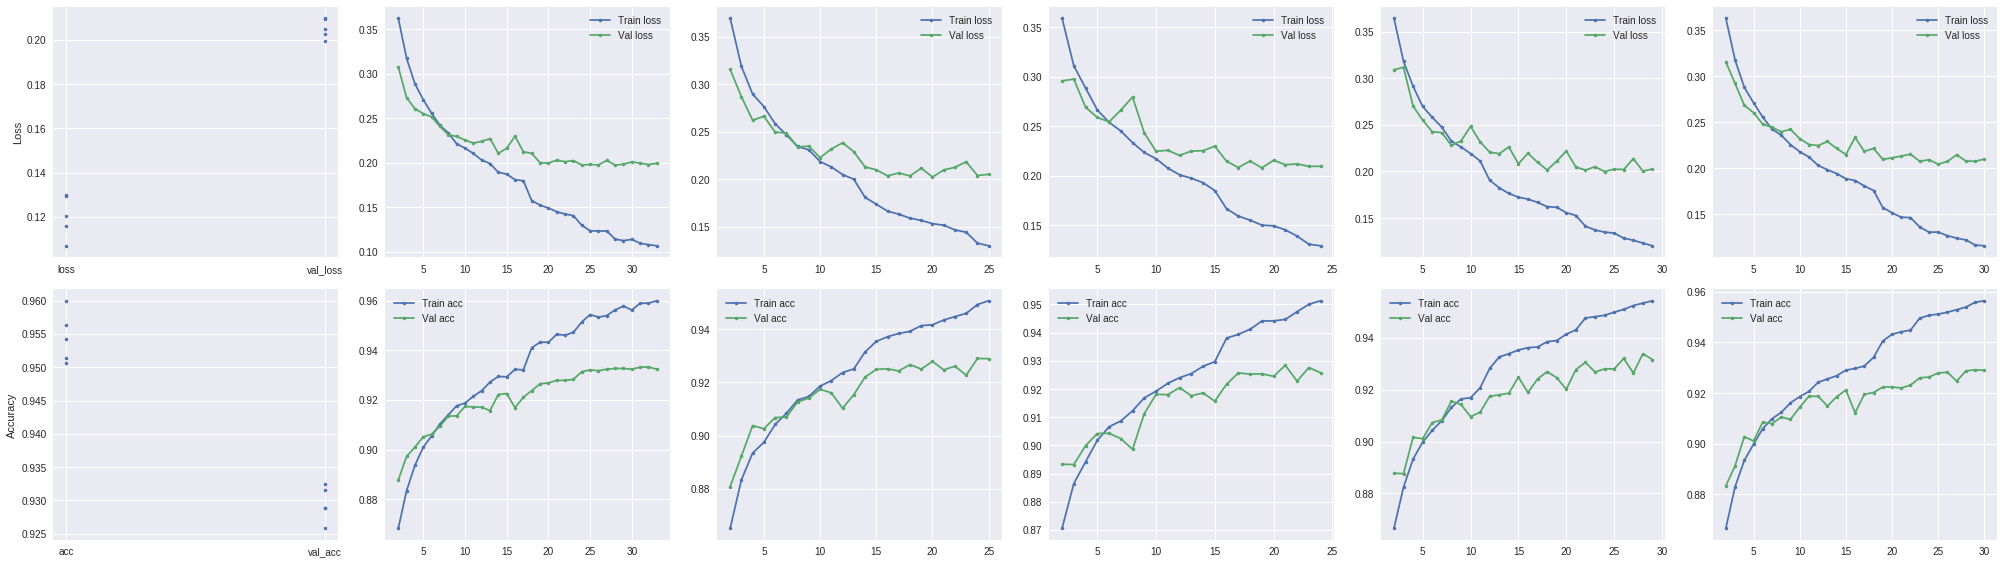

In [9]:
# https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(64, 4, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Conv2D(64, 4, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]

train(make_model, optimizer=lambda: 'adam', callbacks=callbacks);

### Final architecture 

Rerun trial 21

It has only ~50K params

Mean test accuracy ~0.935 from 5 runs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_112 (Bat (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_54 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 14, 14, 32)        9248      
__________

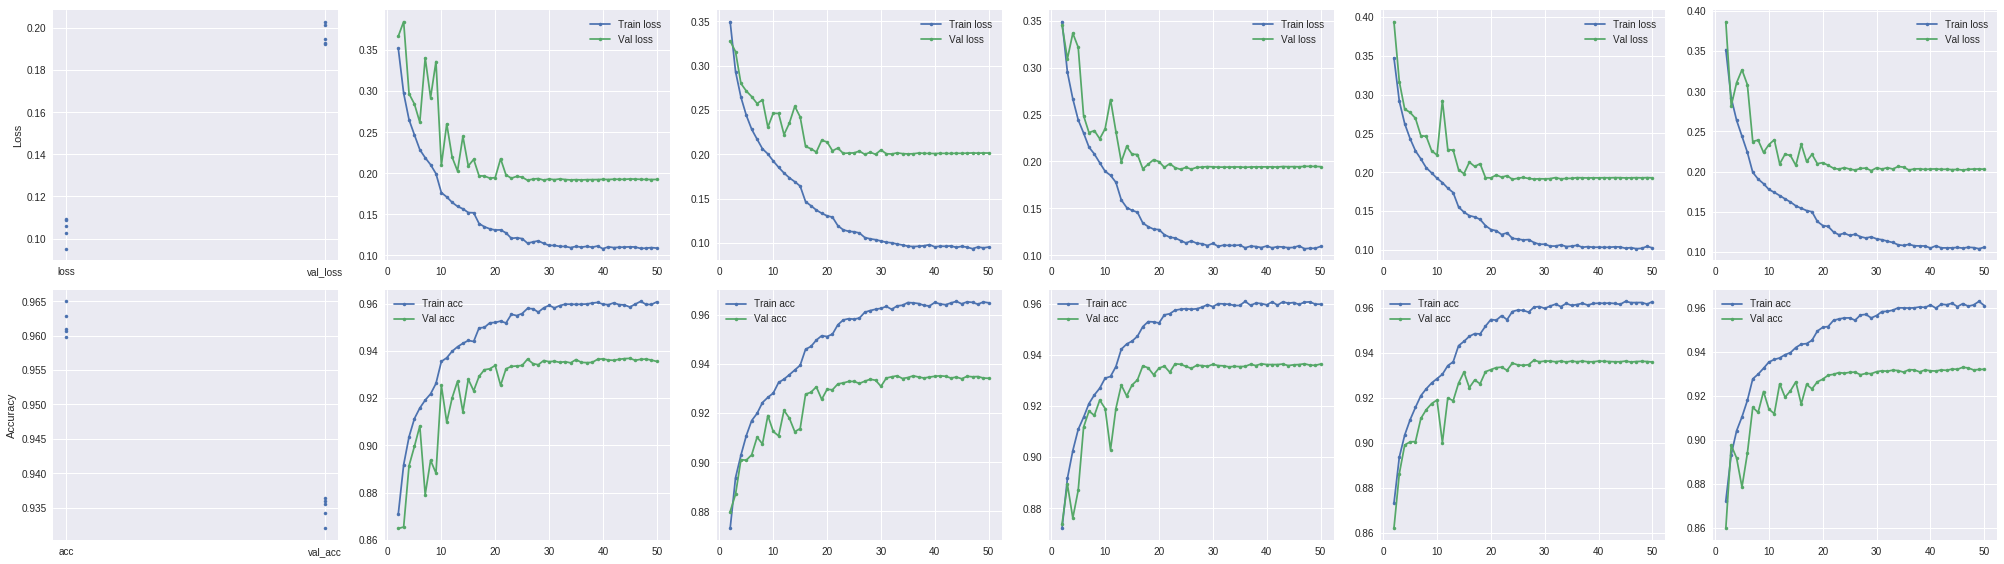

In [21]:
%%time
def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(Conv2D(32, 3, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model, n=5, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1)

### Data augmentation

Mean test accuracy is ~0.933

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_157 (Bat (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_142 (MaxPoolin (None, 7, 7, 32)          0         
__________

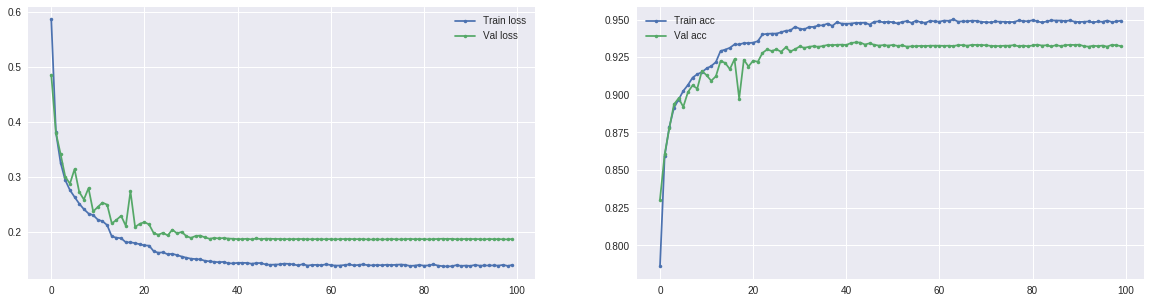

In [58]:
%%time

from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
# model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

# data augmentation generator
datagen = ImageDataGenerator(
#     rotation_range=15, # may not need this as most images are quite "straight"
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
#     vertical_flip=True, # not need this as there aren't any upsidedown images
)

hist = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=256),
    steps_per_epoch=len(X_train) / 256,
    validation_data=(X_test,y_test),
    epochs=100,
    callbacks=[ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)],
    verbose=1,
)

# plot

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], '.-', label='Train loss')
plt.plot(hist.history['val_loss'], '.-', label='Val loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], '.-', label='Train acc')
plt.plot(hist.history['val_acc'], '.-', label='Val acc')
plt.legend();